# PP275 Spatial Data & Analysis

### Anaya Hall


## Research Question
In 2016, California’s Governor Brown signed into law the Short-Lived Climate Pollutant Bill (SB 1383), which targets anthropogenic methane emissions as part of the State’s overall climate change mitigation policy portfolio. This law requires reductions in the amount of organic fraction of municipal solid waste disposal by 50% in the year 2020 and 75% in the year 2025. CalRecycle, the agency in charge of resource reuse and recovery, anticipates that composting facilities will handle the bulk of this material, but at present there are only enough facilities to handle about half of the organic feedstock that will be generated going forward. State policy-makers expect that 50-100 new composting facilities will need to be built to meet the requirements of SB1383. Where should these new facilities be sited, given social, environmental and economic constraints, in order to maximize efficiency? 

### Anticipated Data Sources
County-level biomass resources in bone-dry tonnes, by feedstock type (here, focusing on food scraps and green waste) (already acquired from LBNL scientist Dr. Breunig)
County-level population-weighted centroids (US Census)
Existing composting facilities with information on capacity, accepted feedstock, permit type, and location (CalRecycle’s Solid Waste Inventory System)
Road network with type of road and speed limit (from OpenStreetMap)
Jurisdictional zones: Air Quality Management Districts and Water Quality Management Districts which limit where new solid waste facilities can be sited (CalEPA)
Environmental justice scores (shapefile from CalEPA)
Sites of potential end-use for compost (ie, rangelands and cultivated croplands) (from California Natural Resources Agency)
Series of emission factors for processing compost and roadway travel

### Analysis Plan
This research will combine biomass-generation, existing processing facilities, and potential compost end-use locations via California’s road network to identify optimal siting locations for new compost facilities in the State. The analysis will assign biomass resources targeted by SB1383 to population-weighted county centroids and map these in relation to existing composting facilities. A spatial optimization will be run to evaluate where and what size of composting facilities to build within boundary zones identified as potential sites of new facilities with the objective of minimizing cost of transport, minimizing GHG-emissions in EJ communities, or maximizing resource use (TBD). The road network will be used to connect these nodes of generation and (potential) processing to calculate edge distance, and solve for the given objective.


# Plan (like a lab!)
First, read in input data: CA shapefile, road network (OSM API?), existing processing facilities, biomass generation points, rangelands for application
constraints data: jurisdictions, zoned areas, EJ score

Present above data in series of maps and histograms

Second, optimization under diffrent different objectives:
(use djistkra's algorithim to calculate shortest distance)
shortest road travel (minimizing emissions), cost?, sites of interest, maximizing feedstock use. 
(**see recent lab with djistkra's**)

Method: generate random locations of potential new sites (**see hawaii lab**)(under a constraint of distance to existing facility? and appropriate zones) and for those sites calculate amount of existing capacity, feedstock and land area within certain radius, OR for all pixels in potential site, calculate within range and choose those 50-100 with best

Finally, present series of plots showing potential locations under the three policy objectives, and compare by cost?


In [213]:
#import packages
import pickle
from os.path import join as opj
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon
from shapely.ops import cascaded_union
import matplotlib.pyplot as plt
%matplotlib inline

# set data directory
DATA_DIR = "/Users/anayahall/Box/compostsiting/data"

### Data used in this script:
california_counties_shapefile = "CA_Counties/CA_Counties_TIGER2016.shp"
cal_tracts_shapefile = "tl_2019_06_tract/tl_2019_06_tract.shp"
msw_shapefile = "msw_2020/msw_2020.shp"
tracts_msw_shapefile = "tracts_msw/tracts_msw.shp"

roads_shapefile = "tl_2019_06_prisecroads/tl_2019_06_prisecroads.shp"
compost_facilities_shapefile = "clean_swis/clean_swis.shp" # note: PREVIOUSLY CLEANED!
rangelands_shapefile = "gl_bycounty/grazingland_county.shp"

calenviroscreen_shapefile = "calenviroscreen/CESJune2018Update_SHP/CES3June2018Update_4326.shp"
oppzones_shapefile= "Opportunity Zones/8764oz.shp"

### Data Sources

#### California Counties and Demographics
Census, TigerLine; 
Roads (primary and secondary)

#### MSW Biomass
From JBEI's Biositing Webtool, developed at LBNL
https://biositing.jbei.org/info/about

#### Existing Composting Facilities
CalRecycle's Solid Waste Inventory System (SWIS)

#### Grasslands suitable for grazing (Rangelands)
CalConservation

#### Opportunity Zones or EJ ?
opp zones?
CalEnviroScreen
business regulation and permit zones

In [276]:
# load data

# California counties
california = gpd.read_file(opj(DATA_DIR, 
        california_counties_shapefile))
# set to convention for california 4326 (so all in degrees!)
california = california.to_crs(epsg=4326)

# california census tracts (polygons)
cal_tracts = gpd.read_file(opj(DATA_DIR, 
                              cal_tracts_shapefile))

# tract polygons waith attached msw 
tracts_msw = gpd.read_file(opj(DATA_DIR,
                              tracts_msw_shapefile))
tracts_msw = tracts_msw[(tracts_msw['subtype'] == "MSWfd_wet_dryad_wetad") | (tracts_msw['subtype'] == "MSWgn_dry_dryad")]
tracts_msw['subtype'].replace({'MSWfd_wet_dryad_wetad': 'MSW_food', 
                        'MSWgn_dry_dryad': 'MSW_green'}, inplace = True)


# Municipal Solid Waste (points)
msw = gpd.read_file(opj(DATA_DIR,
                  msw_shapefile))
# filter to just keep food and green waste (subject of regulations)
msw = msw[(msw['subtype'] == "MSWfd_wet_dryad_wetad") | (msw['subtype'] == "MSWgn_dry_dryad")]


# data notes: 
# fog = Fats, Oils, Grease; lb = lumber; cd = cardboard; fd = food;
# pp = paper, gn = green; ot = Other ; suffix describes what the 
# waste is deemed suitable for

# rename categories to be more intuitive
msw['subtype'].replace({'MSWfd_wet_dryad_wetad': 'MSW_food', 
                        'MSWgn_dry_dryad': 'MSW_green'}, inplace = True)
# msw_sum =  msw.groupby(['County', 'subtype']).sum() # may combine???
msw_total = msw.groupby(['ID', 'County']).sum()

# Roads
road_network = gpd.read_file(opj(DATA_DIR, 
                                 roads_shapefile))

# Composting Facilities
composters = gpd.read_file(opj(DATA_DIR,
                                compost_facilities_shapefile))

# Rangelands
rangelands = gpd.read_file(opj(DATA_DIR,
                              rangelands_shapefile))
rangelands = rangelands.to_crs(epsg=4326)

# EJ
cal_EJ = gpd.read_file(opj(DATA_DIR,
                          calenviroscreen_shapefile))
cal_EJ.to_crs(epsg=4326)

opp_zones = gpd.read_file(opj(DATA_DIR,
                          oppzones_shapefile))
opp_zones = opp_zones[opp_zones['STATENAME'] == "California"]

opp_zones = opp_zones.to_crs(epsg=4326)

In [292]:
# I KEEP FUCKING WITH THIS

msw = gpd.read_file(opj(DATA_DIR,
                  msw_shapefile))
# filter to just keep food and green waste (subject of regulations)
msw = msw[(msw['subtype'] == "MSWfd_wet_dryad_wetad") | (msw['subtype'] == "MSWgn_dry_dryad")]
msw['subtype'].replace({'MSWfd_wet_dryad_wetad': 'MSW_food', 
                        'MSWgn_dry_dryad': 'MSW_green'}, inplace = True)




# tracts_msw = gpd.read_file(opj(DATA_DIR,
#                               tracts_msw_shapefile))
# tracts_msw = tracts_msw[(tracts_msw['subtype'] == "MSWfd_wet_dryad_wetad") | (tracts_msw['subtype'] == "MSWgn_dry_dryad")]
# tracts_msw['subtype'].replace({'MSWfd_wet_dryad_wetad': 'MSW_food', 
#                         'MSWgn_dry_dryad': 'MSW_green'}, inplace = True)

# do this better! should prob be a row, not a column! 
# msw_total = msw.groupby(['ID', 'County']).sum()
# msw_total.drop(['wetad', 'dryad', 'wood', 'cellulosic'], axis=1, inplace=True)
# msw_total.rename(columns={'wt': 'total_wt', 'bdt': 'total_bdt'}, inplace = True)
# msw = msw_total.merge(msw, on = "ID")

# tracts_msw_total = tracts_msw.groupby(['TRACTCE', 'County']).sum()
# msw_total.drop(['wetad', 'dryad', 'wood', 'cellulosic'], axis=1, inplace=True)
# msw_total.rename(columns={'wt': 'total_wt', 'bdt': 'total_bdt'}, inplace = True)
# msw = msw_total.merge(msw, on = "ID")

# tract_sum = tracts_msw.groupby('TRACTCE').sum()
# tract_sum_geo = cal_tracts.merge(tract_sum, on = 'TRACTCE')

# tracts_msw



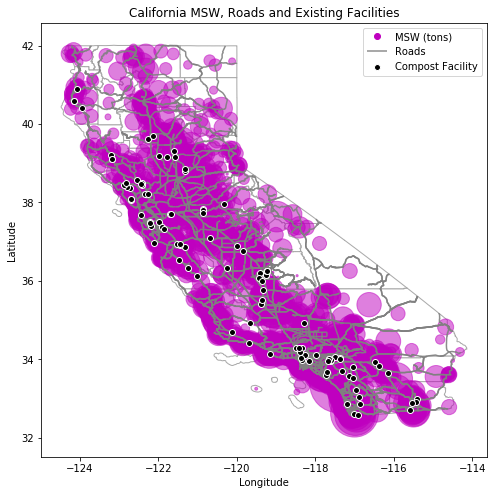

In [297]:
from mpl_toolkits.axes_grid1 import make_axes_locatable



fig, ax = plt.subplots(figsize = (8,8))

# divider = make_axes_locatable(ax)

# cax = divider.append_axes("right", size="5%", pad=0.1)

# for geom in california['geometry']: 
#     if geom.type == 'Polygon':
#         # plot normally
# #         plt.plot(*df.loc[d, 'geometry'].exterior.xy, 'w-', linewidth =1.5)
#         lat, lon = geom.exterior.xy
# #         plt.plot(lat, lon, 'k--')
#         ax.plot(*geom.exterior.xy, 'darkgrey', linewidth = 1.5)
#     elif geom.type == 'MultiPolygon':
#         for p in geom:
#             ax.plot(*p.exterior.xy, 'darkgrey', linewidth =1.5)
california.plot(color = 'white', edgecolor = 'darkgrey', ax = ax)
road_network.plot(color = 'grey', linestyle = '-', 
                  linewidth = 1.5, label = "Roads", ax = ax, alpha = 0.9)

#  THIS ONE FOR POINTS
msw[msw['subtype'] == 'MSW_green'].plot(markersize = 'bdt', 
         legend = True, ax = ax, alpha = 0.5, c = 'm')
ax.plot([],[], 'mo', label = 'MSW (tons)')
# THIS ONE FOR POLYGONS (CHOROPLETH)
# tract_sum_geo.plot(column = 'wt', ax = ax, cmap = 'Purples', 
#                    edgecolor = 'white', legend = True, cax = cax)

composters.plot(marker = 'o', color = 'black', edgecolor = 'white', label = "Compost Facility", 
                ax = ax, zorder = 10)
# cbar.set_label('Org. Fraction MSW')

# opp_zones.plot(color = 'm', ax = ax)
# rangelands.plot(color = "Green", ax = ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title('California MSW, Roads and Existing Facilities')
ax.legend()



In [4]:
# road_network: #see other python notebook!!!!

# build out adjacency matrix

# build out distance matrix

# use shortest path algorith to find shortest route between all 



In [284]:
msw

,ID,total_bdt,total_wt,County,Type,subtype,bdt,wt,wetad,dryad,wood,cellulosic,geometry
0,MW201,286.615176,814.488516,Alameda,msw,MSW_green,195.815374,401.762141,0.0,1.0,0.0,1.0,POINT (-122.0081096421794 37.53715141212642)
1,MW201,286.615176,814.488516,Alameda,msw,MSW_food,90.799802,412.726375,1.0,1.0,0.0,0.0,POINT (-122.0081096421794 37.53715141212642)
2,MW2010,429.003845,1219.121436,Alameda,msw,MSW_green,293.095256,601.355119,0.0,1.0,0.0,1.0,POINT (-122.035337649794 37.53623156577049)
3,MW2010,429.003845,1219.121436,Alameda,msw,MSW_food,135.908590,617.766318,1.0,1.0,0.0,0.0,POINT (-122.035337649794 37.53623156577049)
4,MW20100,430.929199,1224.592809,Alameda,msw,MSW_green,294.410657,604.053979,0.0,1.0,0.0,1.0,POINT (-122.2342802180103 37.75965671440662)
5,MW20100,430.929199,1224.592809,Alameda,msw,MSW_food,136.518543,620.538831,1.0,1.0,0.0,0.0,POINT (-122.2342802180103 37.75965671440662)
6,MW201000,327.341476,930.222456,Kern,msw,MSW_green,223.639566,458.850135,0.0,1.0,0.0,1.0,POINT (-118.9229277629319 35.37973693523369)
7,MW201000,327.341476,930.222456,Kern,msw,MSW_food,103.701911,471.372321,1.0,1.0,0.0,0.0,POINT (-118.9229277629319 35.37973693523369)
8,MW201001,731.873693,2079.801654,Kern,msw,MSW_green,500.015814,1025.902206,0.0,1.0,0.0,1.0,POINT (-119.0269531745941 35.30354169272959)
9,MW201001,731.873693,2079.801654,Kern,msw,MSW_food,231.857879,1053.899449,1.0,1.0,0.0,0.0,POINT (-119.0269531745941 35.30354169272959)


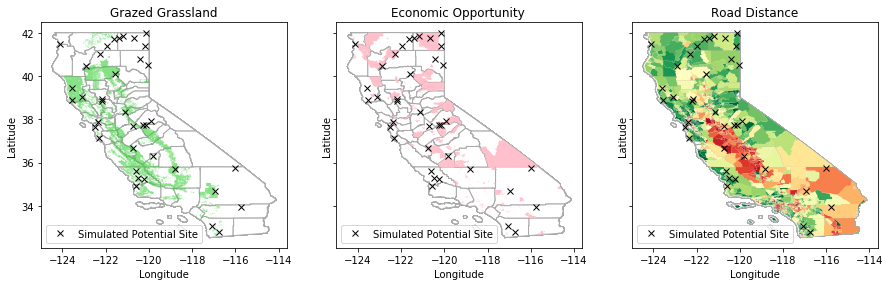

In [345]:
# OKAY SKIP THAT FOR NOW, start with loop that goes through 
# each point and adds up available feedstock, existing capacity, etc

# simulating random points:

# number of events to simulate
N = 100

# AREA to cast random numbers in 
# 10 degrees from -125
lon = np.random.random(N) * 10 - 125
# 10 degrees from 32
lat = np.random.random(N) * 10 + 32

# this reorganizes the points such that the input format
# is consistent with what MultiPoint() expects
potential_sites = MultiPoint(np.vstack((lon, lat)).T)

# california (union of all conties for full state)
california_state =  gpd.GeoSeries(cascaded_union(california['geometry']))[0]

# intersection- only keep sites within state boundary
potential_sites = potential_sites.intersection(california_state)

# plot to make sure this looks like I expect

f, ax = plt.subplots(ncols = 3, sharey = True, figsize = (15, 6))
for point in potential_sites:
    lat, lon = point.x, point.y
#     print(type(point))
    for a in range(3):
        ax[a].plot(lat, lon, 'kx')
        california.plot(color = 'white', edgecolor = 'darkgrey', ax = ax[a])
#     for geom in opp_zones['geometry']:
#         if point.intersection(geom):
#             glat, glon = geom.exterior.xy
#             ax[0].plot(glat, glon, color = 'pink', alpha = '0.6')
      

# ADD TO THIS FOR 'PRELIMINARY RESULTS'
# rangeland locations

rangelands.plot(color = "limegreen", ax = ax[0], alpha = 0.6, label = 'Rangeland')
# oppzones
opp_zones.plot(color = 'pink', ax = ax[1], label = 'Opportunity Zones')

# close to roads???    
# road_network.plot(color = 'c', linestyle = '-', 
#                   linewidth = 0.8, label = "Roads", ax = ax[2], alpha = 0.7)   
# EJ
cal_EJ.plot(column = 'CIscoreP', cmap = 'RdYlGn_r', ax = ax[2])

ax[0].set_title("Grazed Grassland")
ax[1].set_title("Economic Opportunity ")
ax[2].set_title("Road Distance")

for a in range(3):        
    ax[a].plot([], [], 'kx', label = 'Simulated Potential Site')
    ax[a].set_xlabel("Longitude")
    ax[a].set_ylabel("Latitude")
    ax[a].legend()   
    
plt.show()




Text(0.5,1,'EJ Score')

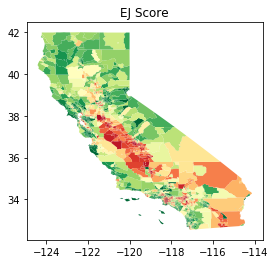

In [346]:
# calenviroscreen_shapefile = "calenviroscreen/CESJune2018Update_SHP/CES3June2018Update_4326.shp"

# cal_EJ = gpd.read_file(opj(DATA_DIR,
#                           calenviroscreen_shapefile))
# cal_EJ.crs

cal_EJ.plot(column = 'CIscoreP', cmap = 'RdYlGn_r')
plt.title("EJ Score")

looping through site number:  0


KeyError: 897

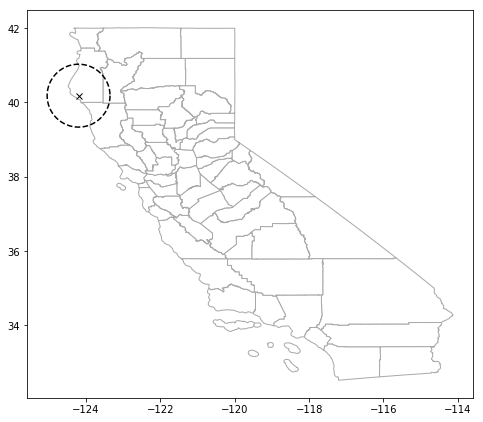

In [299]:
# (maybe wrap this into function to calculate radius throughout california!)

# Calculate buffer around each point and get expected value of new site there!
#rad = deg * pi/180
lat = california_state.centroid.y * np.pi/180 # in radians

km_per_degree = np.cos(lat)*111.321

buffer_radius = 75/km_per_degree

f, ax = plt.subplots(figsize = (8,8))
california.plot(color = 'white', edgecolor = 'darkgrey', ax = ax)

# CREATE EMPTY ARRAY FOR POTENTIAL SITES VALUES
site_results = np.zeros(len(potential_sites))
# LOOP THROUGH ALL POINTS
for p, point in enumerate(potential_sites):
    if p % 10 == 0:
        print("looping through site number: ", p)
    value = 0
    # buffer point
    buffer = point.buffer(buffer_radius)
    blat, blon = buffer.exterior.xy
    lat, lon = point.x, point.y
    ax.plot(lat, lon, 'kx')
    ax.plot(blat, blon, 'k--')
    for f, geom in enumerate(msw['geometry']):
        if geom.intersection(buffer):
#             print('FOUND ONE', p, f)
#             print(f)
            ax.scatter(geom.x, geom.y, c = 'm', s = (msw.loc[f, 'total_wt'])/10, 
                       alpha = '0.2')
#             geom.plot(markersize = 'total_wt' ax = ax, alpha = 0.5)
            value += msw.iloc[f, :]['wt']
    for c, geom in enumerate(composters['geometry']):
#         print(c)
#         print(geom.type)
        if geom.intersection(buffer):
            value += -(composters.iloc[c, :]['cap_m3'])
            ax.scatter(geom.x, geom.y, marker = 'o', color = 'black', 
                       edgecolor = 'white', alpha = '0.9')
    if value > 100:
#         print('YAY')
        site_results[p] = value
ax.plot([], [], 'kx', label = 'Potential Site')    
ax.plot([], [], 'k--', label = 'Buffer Zone')   
ax.plot([], [], 'mo', alpha = 0.5, label = 'MSW generation')
ax.plot([], [], marker = 'o', color = 'black', label = 'Existing Facility', 
        linestyle = 'None')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
    
# site_results

In [2]:
site_results